<a href="https://colab.research.google.com/github/Vikram-max812/Quant/blob/main/Quant_Predicting_Future_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 PART 1: Data Fetching + Cleaning

In [34]:
# 📦 Install required library
!pip install yfinance --quiet

# 📌 STEP 1: Configurable Variables
STOCK_SYMBOL = "^NSEI"             # You can change this to "AAPL", "TSLA", etc.
START_DATE = "2022-01-01"
END_DATE = "2024-12-31"
FREQ = "1d"                        # '1d' for daily, '1wk' for weekly

# 📥 STEP 2: Fetch OHLCV Data
import yfinance as yf
import pandas as pd

data = yf.download(tickers=STOCK_SYMBOL, start=START_DATE, end=END_DATE, interval=FREQ)

# 🧼 STEP 3: Cleaning Data
data.dropna(inplace=True)
data.reset_index(inplace=True)  # Reset to use date as a column
data = data.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adj_close',
    'Volume': 'volume'
})

# 📊 Show head
print(f"Data shape: {data.shape}")
data.head()


/tmp/ipython-input-34-1789147199.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=STOCK_SYMBOL, start=START_DATE, end=END_DATE, interval=FREQ)
[*********************100%***********************]  1 of 1 completed

Data shape: (738, 6)


Price,date,close,high,low,open,volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
0,2022-01-03,17625.699219,17646.650391,17383.300781,17387.150391,200500
1,2022-01-04,17805.250000,17827.599609,17593.550781,17681.400391,247400
2,2022-01-05,17925.250000,17944.699219,17748.849609,17820.099609,251500
3,2022-01-06,17745.900391,17797.949219,17655.550781,17768.500000,236500
4,2022-01-07,17812.699219,17905.000000,17704.550781,17797.599609,239300


PART 2 — Regime Feature Engineering

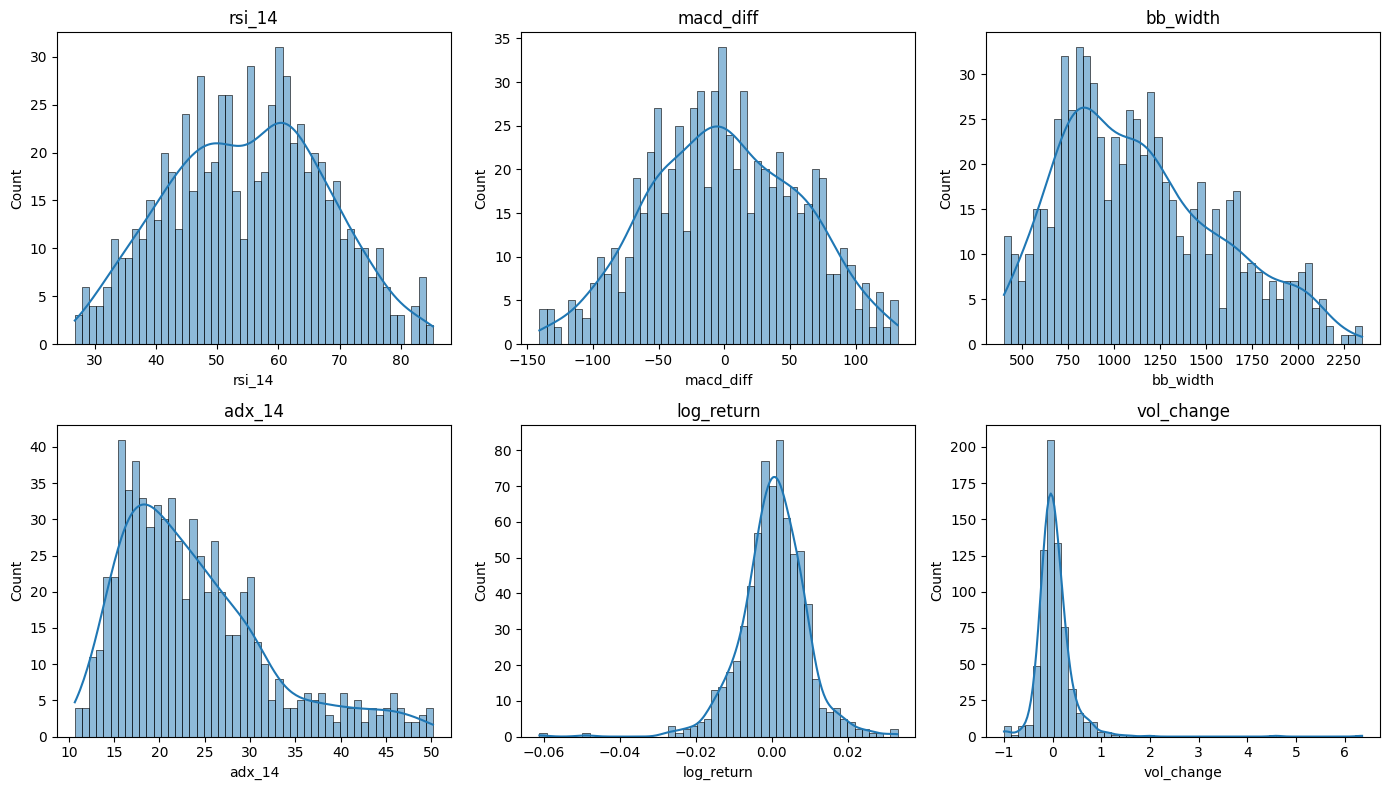

In [35]:
# 📦 Ensure TA-Lib-style indicator support
!pip install ta --quiet

# 📚 Imports
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns

# 🧮 STEP 1: Add Indicators to Data
df = data.copy()

# Rename columns to a single level
df.columns = ['date', 'close', 'high', 'low', 'open', 'volume']


# ✅ 1. RSI (Relative Strength Index)
df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi().values.ravel()

# ✅ 2. MACD Histogram
macd = ta.trend.MACD(close=df['close'])
df['macd_diff'] = macd.macd_diff().values.ravel()

# ✅ 3. Bollinger Band Width
bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bb_width'] = (bb.bollinger_hband() - bb.bollinger_lband()).values.ravel()

# ✅ 4. ADX (Average Directional Index)
df['adx_14'] = ta.trend.ADXIndicator(
    high=df['high'], low=df['low'], close=df['close'], window=14
).adx().values.ravel()

# ✅ 5. Log Returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# ✅ 6. Volume % Change
df['vol_change'] = df['volume'].pct_change()

# 🧹 STEP 2: Drop NaNs
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# 🎯 STEP 3: Select Regime Features
regime_features = df[['rsi_14', 'macd_diff', 'bb_width', 'adx_14', 'log_return', 'vol_change']]

# 🔍 STEP 4: Visualize Distributions
plt.figure(figsize=(14, 8))
for i, col in enumerate(regime_features.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

PART 3: Regime Clustering with KMeans + Regime Labeling

/tmp/ipython-input-36-2975793545.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regime_features.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-36-2975793545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regime_features.dropna(inplace=True)


Silhouette Score for k=2: 0.2070
Silhouette Score for k=3: 0.2214
Silhouette Score for k=4: 0.2027
Silhouette Score for k=5: 0.2136
Silhouette Score for k=6: 0.2108


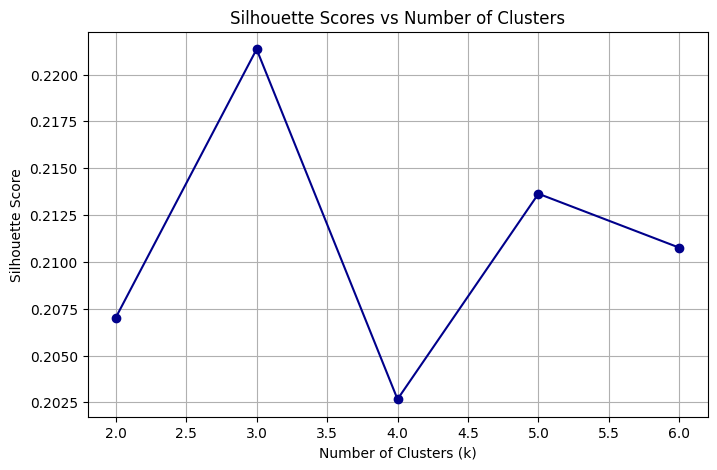

✅ Optimal number of regimes = 3


In [36]:
# 📚 Imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np # Import numpy to use np.inf

# 📦 STEP 1: Normalize the regime features
scaler = StandardScaler()

# Handle potential infinite values before scaling
regime_features.replace([np.inf, -np.inf], np.nan, inplace=True)
regime_features.dropna(inplace=True)

regime_scaled = scaler.fit_transform(regime_features)

# 🔍 STEP 2: Try KMeans for k in range(2, 6)
silhouette_scores = []
K_range = range(2, 7)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init for KMeans
    labels = kmeans.fit_predict(regime_scaled)
    score = silhouette_score(regime_scaled, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

# 📊 STEP 3: Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='darkblue')
plt.title("Silhouette Scores vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# ✅ STEP 4: Choose best k (max silhouette score)
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"✅ Optimal number of regimes = {best_k}")

PART 4: Assign Regime Labels + Visualize on Price Chart

/tmp/ipython-input-37-3633506754.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Set1", best_k)


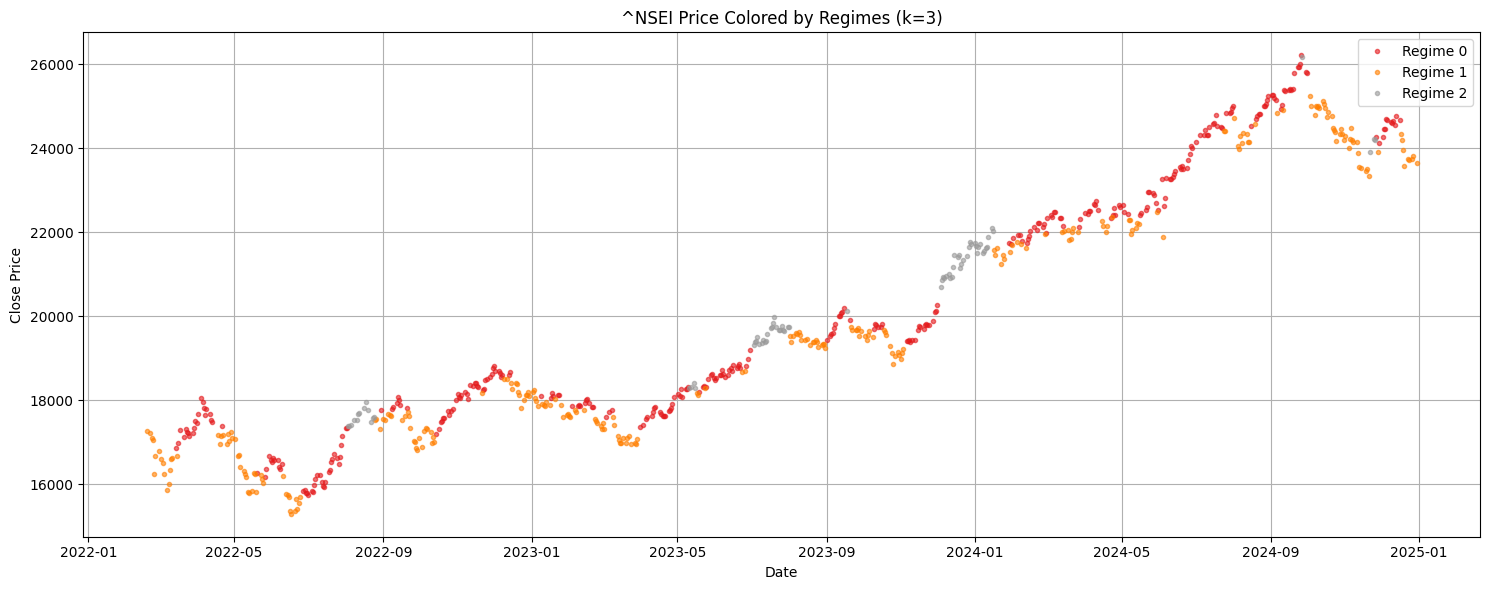

In [37]:
# 🧠 STEP 1: Apply KMeans with optimal number of clusters
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# Ensure df has the same index as regime_features before assigning labels
df_aligned = df.loc[regime_features.index].copy()
df_aligned['regime'] = final_kmeans.fit_predict(regime_scaled)

# 🎨 STEP 2: Plot Close Price with Regime Color Bands
import matplotlib.dates as mdates
from matplotlib import cm

# Color map with enough distinct shades
cmap = cm.get_cmap("Set1", best_k)

plt.figure(figsize=(15, 6))
for r in range(best_k):
    regime_df = df_aligned[df_aligned['regime'] == r]
    plt.plot(regime_df['date'], regime_df['close'], '.', label=f"Regime {r}", color=cmap(r), alpha=0.6)

plt.title(f"{STOCK_SYMBOL} Price Colored by Regimes (k={best_k})")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 PART 5: Target Creation — 5-Day Forward Volatility

In [38]:
# 🧠 STEP: Compute Log Returns Again (in case not in scope)
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 🎯 STEP: 5-Day Forward Rolling Std as Target
# This computes the standard deviation of returns over the *next* 5 days
FUTURE_WINDOW = 5
df['volatility_5d'] = df['log_return'].shift(-FUTURE_WINDOW + 1).rolling(window=FUTURE_WINDOW).std()

# 🧹 STEP: Drop final NaNs caused by forward shift
df.dropna(subset=['volatility_5d'], inplace=True)
df.reset_index(drop=True, inplace=True)

# ✅ Preview
df[['date', 'log_return', 'volatility_5d']].tail()


,date,log_return,volatility_5d
690,2024-12-17,-0.013560,0.008938
691,2024-12-18,-0.005652,0.008577
692,2024-12-19,-0.010266,0.008963
693,2024-12-20,-0.015322,0.008461
694,2024-12-23,0.007011,0.005185


PART 6: Train & Save One Linear Regression Model Per Regime

In [39]:
# 📚 Imports
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import os
import numpy as np # Import numpy for sqrt

# 📁 STEP 0: Create directory for saving models
os.makedirs("models_per_regime", exist_ok=True)

# 🧾 STEP 1: Define Feature Columns
feature_cols = [
    'rsi_14', 'macd_diff', 'bb_width', 'adx_14',
    'log_return', 'vol_change'
]

# Merge volatility_5d from df into df_aligned
df_aligned = df_aligned.merge(df[['date', 'volatility_5d']], on='date', how='left')
df_aligned.dropna(subset=['volatility_5d'], inplace=True) # Drop rows where volatility_5d is NaN after merge

# 🧠 STEP 2: Loop through each regime and train model
regime_models = {}
metrics_table = []

for r in sorted(df_aligned['regime'].unique()):
    print(f"\n🚀 Training Model for Regime {r}")

    regime_df = df_aligned[df_aligned['regime'] == r].copy()

    X = regime_df[feature_cols]
    y = regime_df['volatility_5d']

    # Split into Train/Test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Initialize and Train
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) # Calculate RMSE manually
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"✅ RMSE: {rmse:.5f}, MAE: {mae:.5f}, R²: {r2:.5f}")

    # Save Model
    filename = f"models_per_regime/model_regime_{r}.pkl"
    pickle.dump(model, open(filename, "wb"))

    # Store model and metrics
    regime_models[r] = model
    metrics_table.append({
        "Regime": r,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Samples": len(regime_df)
    })

# 📊 Summary Table
pd.DataFrame(metrics_table)


🚀 Training Model for Regime 0
✅ RMSE: 0.00386, MAE: 0.00318, R²: -0.83505

🚀 Training Model for Regime 1
✅ RMSE: 0.00599, MAE: 0.00481, R²: -3.76294

🚀 Training Model for Regime 2
✅ RMSE: 0.00573, MAE: 0.00440, R²: -2.25359


,Regime,RMSE,MAE,R2,Samples
0,0,0.003859,0.003183,-0.835053,347
1,1,0.005993,0.004812,-3.762942,267
2,2,0.005730,0.004405,-2.253585,75


PART 7: Live Regime Detection & Volatility Prediction

In [40]:
# ✅ Imports (if not already in scope)
import pickle
import numpy as np

# 🧠 STEP 1: Get the most recent available row
latest_row = df.iloc[-1:].copy()
latest_features = latest_row[feature_cols]

# 🎯 STEP 2: Standardize the regime indicators (same scaler as before)
latest_scaled = scaler.transform(latest_features)

# 🧠 STEP 3: Predict the current regime
current_regime = final_kmeans.predict(latest_scaled)[0]
print(f"🟢 Current Regime Detected: Regime {current_regime}")

# 📥 STEP 4: Load corresponding saved model
model_path = f"models_per_regime/model_regime_{current_regime}.pkl"
loaded_model = pickle.load(open(model_path, "rb"))

# 📈 STEP 5: Predict 5-day forward volatility
predicted_volatility = loaded_model.predict(latest_features)[0]
print(f"📊 Predicted 5-Day Volatility: {predicted_volatility:.6f}")


🟢 Current Regime Detected: Regime 1
📊 Predicted 5-Day Volatility: 0.008653


PART 8: Exploratory Data Analysis (EDA) Section

/tmp/ipython-input-41-2056437531.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


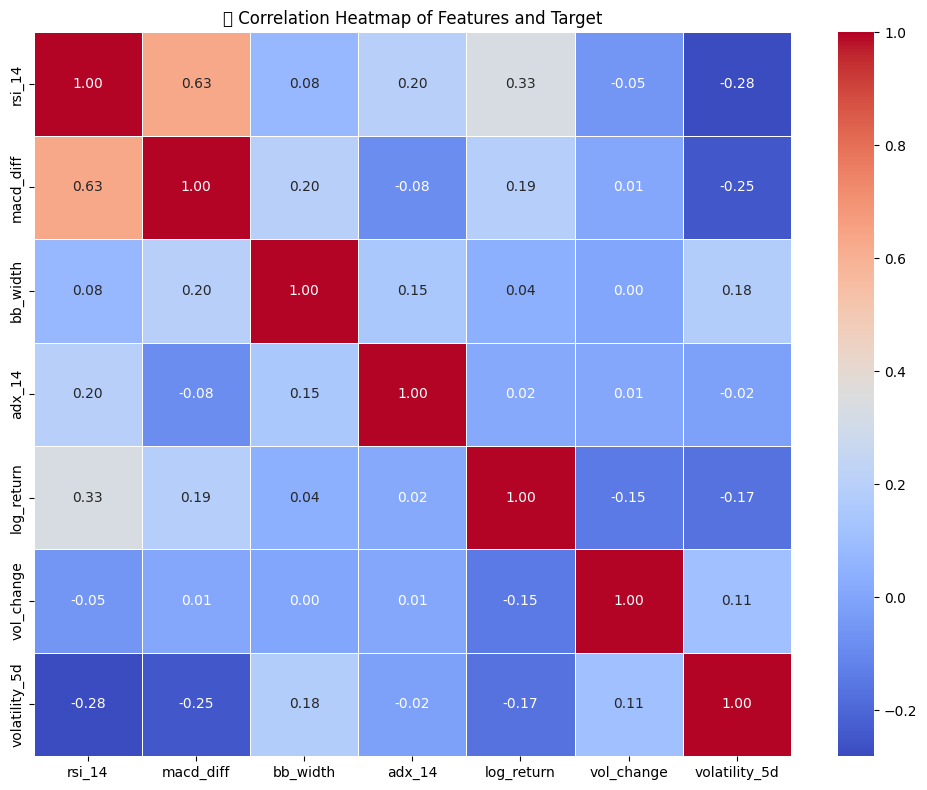

In [41]:
# 📊 Correlation Heatmap
plt.figure(figsize=(10, 8))
heatmap_features = feature_cols + ['volatility_5d']
corr = df[heatmap_features].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("🔍 Correlation Heatmap of Features and Target")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


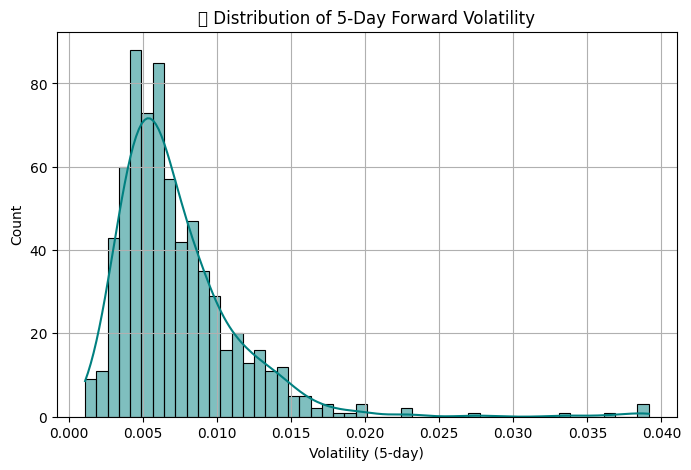

In [42]:
# Distribution of Target Variable
plt.figure(figsize=(8, 5))
sns.histplot(df['volatility_5d'], bins=50, kde=True, color='teal')
plt.title("📈 Distribution of 5-Day Forward Volatility")
plt.xlabel("Volatility (5-day)")
plt.grid(True)
plt.show()
